In [34]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import tensorflow as tf
from scipy import stats
import numpy as np
import sklearn.metrics as metrics

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=10)        #22
rc('xtick', labelsize=8)  #15
rc('ytick', labelsize=8)  #15
rc('legend', fontsize=8)  #15
rc('text.latex', preamble=r'\usepackage{amsmath}')

# Plots have dimension (w,h)
w = 3.5
h = 3.25       

from flows import *

import sys
import os

sys.path.append('../')
from utils.training import *
from utils.losses import *

np.random.seed(666)

In [36]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [37]:
mc = np.load("../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt =  mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m =   mc['sim_jets'][:, 3]

sim = np.vstack([sim_pt, sim_eta, sim_phi, sim_m]).T

In [38]:
dat = np.load("../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dat_pt =  dat['sim_jets'][:, 0] # dat[:, 0]
dat_eta = dat['sim_jets'][:, 1]
dat_phi = dat['sim_jets'][:, 2]
dat_m =   dat['sim_jets'][:, 3]

dat = np.vstack([dat_pt, dat_eta, dat_phi, dat_m]).T

In [39]:
n, d = dat.shape

# 1D Flow

In [7]:
data = dat[:, 0].reshape(dat.shape[0], -1)

In [8]:
b_s = 100
n_e = 10
lr = 1e-3

In [ ]:
%%time
target = flow(data, 
              ckpt_path = 'dat1D/ckpt',
              batch_size = b_s,
              num_epochs = n_e,
              lr = lr)

In [ ]:
samp = target.sample(n)

In [ ]:
bins = np.linspace(0, 500, 50)
plt.hist(data, bins = bins)
plt.hist(samp.numpy(), bins = bins)
plt.xlim(-100, 500)
plt.savefig('b_s = {}, n_e = {}, lr = {}.png'.format(b_s, n_e, lr))

# Load Flows

In [40]:
dat_target = make_target(d)
sim_target = make_target(d)

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

In [41]:
dat_ckpt.restore('dat4/ckpt-79')
sim_ckpt.restore('sim2/ckpt-40')

In [42]:
dat_smp = dat_target.sample(n)
sim_smp = sim_target.sample(n)

# Histograms

In [12]:
def ratio_hist(truth, fit,
               labels,
               color = "gray",
               figsize = (8, 8),
               x_lim = None,
               y_lim = None,
               title = None,
               filename = None):
    fig, axs = plt.subplots(2, 1,
                            figsize = figsize,
                            sharex = True, 
                            gridspec_kw = {'height_ratios': [2, 1]})
    
    truth = truth[(truth > x_lim[0]) & (truth < x_lim[1])]
    fit = fit[(fit > x_lim[0]) & (fit < x_lim[1])]
    
    t_hist = axs[0].hist(truth, bins = 50, density = True, color = color, alpha = 0.25, label = labels[0])
    f_hist = axs[0].hist(fit, bins = 50, density = True, histtype = 'step', color = 'red', label = labels[1])
    
    axs[0].minorticks_on()
    axs[0].tick_params(direction='in', which='both')
    axs[0].legend()
    
    if y_lim:
        axs[0].set_ylim(y_lim[0], y_lim[1])
    if x_lim:
        axs[0].set_xlim(x_lim[0], x_lim[1])
    
    bins = (f_hist[1] + np.diff(f_hist[1]).mean() / 2)[:-1]
    axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
    axs[1].axhline(1,color="gray", lw=0.5)
    
    axs[1].minorticks_on()
    axs[1].tick_params(direction='in', which='both')
    axs[1].set_ylim(0, 2)
    
    plt.xlabel(labels[2])
    
    if title:
        axs[0].set_title(title, loc = "right")
    if filename:
        plt.savefig(filename, 
                    dpi = 300,
                    transparent = True,
                    bbox_inches = 'tight')

## Data

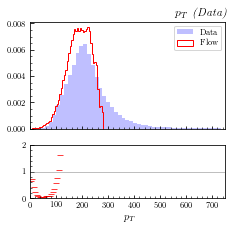

In [13]:
ratio_hist(dat[:, 0], dat_smp[:, 0], 
           labels = ['Data', 'Flow', r'$p_T$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $p_T$ (Data)',
           x_lim = (0, 750),
           filename = '../plots/zenodo/flows/dat4/pT_data.png'
          )

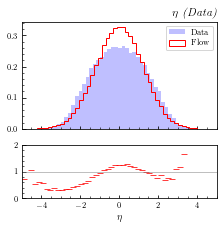

In [14]:
ratio_hist(dat[:, 1], dat_smp[:, 1], 
           labels = ['Data', 'Flow', r'$\eta$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $\eta$ (Data)',
           x_lim = (-5, 5),
           filename = '../plots/zenodo/flows/dat4/eta_data.png'
          )

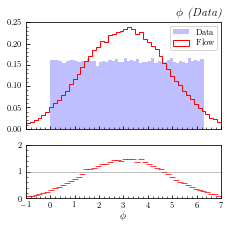

In [15]:
ratio_hist(dat[:, 2], dat_smp[:, 2], 
           labels = ['Data', 'Flow', r'$\phi$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $\phi$ (Data)',
           x_lim = (-1, 7),
           filename = '../plots/zenodo/flows/dat4/phi_data.png'
          )

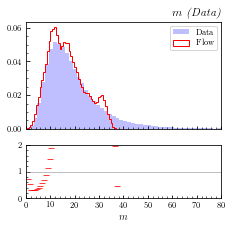

In [16]:
ratio_hist(dat[:, 3], dat_smp[:, 3], 
           labels = ['Data', 'Flow', r'$m$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $m$ (Data)',
           x_lim = (0, 80),
           filename = '../plots/zenodo/flows/dat4/m_data.png'
          )

## MC

In [ ]:
ratio_hist(sim[:, 0], sim_smp[:, 0], 
           labels = ['MC', 'Flow', r'$p_T$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $p_T$ (MC)',
           x_lim = (0, 750),
           filename = '../plots/zenodo/flows/sim2/pT_mc.png'
          )

In [ ]:
ratio_hist(sim[:, 1], sim_smp[:, 1], 
           labels = ['MC', 'Flow', r'$\eta$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\eta$ (MC)',
           x_lim = (-5, 5),
           filename = '../plots/zenodo/flows/sim2/eta_mc.png'
          )

In [ ]:
ratio_hist(sim[:, 2], sim_smp[:, 2], 
           labels = ['MC', 'Flow', r'$\phi$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\phi$ (MC)',
           x_lim = (-1, 7),
           filename = '../plots/zenodo/flows/sim2/phi_mc.png'
          )

In [ ]:
ratio_hist(sim[:, 3], sim_smp[:, 3], 
           labels = ['MC', 'Flow', r'$m$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $m$ (MC)',
           x_lim = (0, 80),
           filename = '../plots/zenodo/flows/sim2/m_mc.png'
          )

# Classification

## MC

In [ ]:
X_bkgd = sim_smp
X_sgnl = sim

In [ ]:
np.random.seed(666)

# Create full dataset; randomly sample points from Data or Flow with chance 1/2.
y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
X = np.zeros_like(X_bkgd)

X[y == 0] = X_bkgd[y == 0]
X[y == 1] = X_sgnl[y == 1]

# Take 70% of data to be training data.
N_trn = int(0.7*n)
trn_idx = np.random.choice(range(n), N_trn, replace = False)
tst_idx = [n for n in range(n) if n not in trn_idx]

X_trn = X[trn_idx]
y_trn = y[trn_idx]

X_tst = X[tst_idx]
y_tst = y[tst_idx]

data, m, s = split_data(X_trn, y_trn)

In [ ]:
params = {'loss':bce, 'd':4}

clf, trace = train(data, **params)

In [ ]:
y_hat = clf.predict(X_tst)
fpr, tpr, ts = metrics.roc_curve(y_tst, y_hat)
auc = metrics.roc_auc_score(y_tst, y_hat)

In [ ]:
fig, ax = plt.subplots(figsize = (w, h))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, ls = ':', c = 'k', lw = 1)

plt.title('\it ROC Curve for MC', loc = 'right')
plt.text(0.05, 0.9, 'AUC: {}'.format(round(auc, 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both')
plt.gca().set_aspect('equal')

plt.savefig('../plots/zenodo/flows/sim/mc_roc.png', dpi = 300, transparent = True,
            bbox_inches = 'tight')

## Data

In [53]:
X_bkgd = dat_smp
X_sgnl = dat

In [93]:
np.random.seed(666)

# Create full dataset; randomly sample points from Data or Flow with chance 1/2.
y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
X = np.zeros_like(X_bkgd)

X[y == 0] = X_bkgd[y == 0]
X[y == 1] = X_sgnl[y == 1]

# Take 70% of data to be training data.
N_trn = int(0.7*n)
trn_idx = np.random.choice(range(n), N_trn, replace = False)
tst_idx = [n for n in range(n) if n not in trn_idx]

X_trn = X[trn_idx]
y_trn = y[trn_idx]

X_tst = X[tst_idx]
y_tst = y[tst_idx]

data, m, s = split_data(X_trn, y_trn)

In [56]:
params = {'loss':bce, 'd':1}

clf, trace = train(data, **params)

0.6159173846244812 	 99	

In [99]:
from sklearn.ensemble import AdaBoostClassifier
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_trn, y_trn)

AdaBoostClassifier()

In [95]:
from sklearn.linear_model import LogisticRegression
lg_clf = LogisticRegression()
lg_clf.fit(X_trn, y_trn)

LogisticRegression()

In [100]:
y_hat = ab_clf.predict_proba(X_tst)[:, 1]
fpr, tpr, ts = metrics.roc_curve(y_tst, y_hat)
auc = metrics.roc_auc_score(y_tst, y_hat)

In [96]:
y_hat = lg_clf.predict_proba(X_tst)[:, 1]
fpr, tpr, ts = metrics.roc_curve(y_tst, y_hat)
auc = metrics.roc_auc_score(y_tst, y_hat)

In [57]:
y_hat = clf.predict(X_tst)
fpr, tpr, ts = metrics.roc_curve(y_tst, y_hat)
auc = metrics.roc_auc_score(y_tst, y_hat)

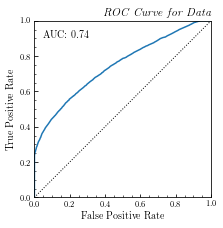

In [101]:
fig, ax = plt.subplots(figsize = (w, h))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, ls = ':', c = 'k', lw = 1)

plt.title('\it ROC Curve for Data', loc = 'right')
plt.text(0.05, 0.9, 'AUC: {}'.format(round(auc, 2)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both')
plt.gca().set_aspect('equal')

#plt.savefig('../plots/zenodo/flows/dat4/data_roc.png', dpi = 300, transparent = True,
#            bbox_inches = 'tight')